# Visualización del proceso de aprendizaje en Regresión Lineal con descenso de gradiente

Solo corre localmente (no usar en Google colab o similar)

Funciones auxiliares (solo ejecutar, y seguir más abajo)

In [4]:
###############################################################################
%matplotlib notebook

!pip install -q redes-neuronales-util
import rnutil

from IPython.display import display, clear_output
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import os
import matplotlib.patches as patches
from collections import namedtuple
from matplotlib import cm


OptimizationState = namedtuple('OptimizationState', ['error_history','max_iterations'])
IterationState = namedtuple('IterationState', ['iteration','m','b','dEdm', 'dEdb','yhat','errors','mean_error'])
OptimalModel = namedtuple('Model', ['m', 'b','error'])

PlotState = namedtuple('PlotState', ['figure','axes','legends'])

## MODELO OPTIMO CON METODO ANALITICO DE SKLEARN
def optimal_model(x,y):
    from sklearn import datasets, linear_model
    regr = linear_model.LinearRegression()
    regr.fit(x.reshape(-1, 1),y)
    optimal_m=regr.coef_[0]
    optimal_b=regr.intercept_
    optimal_yhat=x*optimal_m+optimal_b
    optimal_error=((optimal_yhat-y)**2).mean()
    return OptimalModel(optimal_m,optimal_b,optimal_error)
    
## FUNCIONES DE DIBUJO
def init_data(ax_data,x,y,optimal,m,b):
    ax_data.scatter(x,y,color="blue")
    
    x_pad=10
    min_x,max_x=x.min()-x_pad,x.max()+x_pad
    ax_data.plot([min_x,max_x],[min_x*optimal.m+optimal.b,max_x*optimal.m+optimal.b],color="cyan")
    ax_data.plot([min_x,max_x],[min_x*m+b,max_x*m+b],color="red")
    
    ax_data.set_xlabel("x (Horas estudiadas)")
    ax_data.set_ylabel("y (Nota)")
    
def init_error_history(ax_error):
    ax_error.set_xlabel("Iteración")
    ax_error.set_ylabel("Error")
    ax_error.set_title("Historial de Error")
    
def init_contour(ax_contour,x,y,optimal,m,b):    
    ax_contour.set_xlabel("m")
    ax_contour.set_ylabel("b")
#     ax3.set_zlabel("E")
    ax_contour.set_title("Contorno de E(m,b) ")
    detail=0.05
    param_range=8
    M = np.arange(-param_range, param_range, detail)
    B = np.arange(-param_range, param_range, detail)
    Ms, Bs = np.meshgrid(M, B)
    E=np.zeros_like(Ms)
    n=len(x)
    for i in range(n):
        Yi=Ms*x[i]+Bs
        E+=(Yi-y[i])**2
    E/=n

    surf=ax_contour.contourf(Ms,Bs,E,cmap='coolwarm')
    
    ax_contour.scatter([optimal.m], [optimal.b],c="green")
    plt.colorbar(surf, shrink=0.5, aspect=5)
    
def init_plot(x,y,optimal,m,b):
    
    figure=plt.figure(figsize=(10,4))
    plt.suptitle('Entrenamiento de modelo lineal')
    ax_data=figure.add_subplot(1,3,1)
    ax_error=figure.add_subplot(1,3,2)
    ax_contour=figure.add_subplot(1,3,3)
    axes=(ax_data,ax_error,ax_contour)
    
    init_data(ax_data,x,y,optimal,m,b)
    init_error_history(ax_error)
    init_contour(ax_contour,x,y,optimal,m,b)
    plt.tight_layout()
    
    
    
    return PlotState(figure,axes,None)

def visualizar(plot_state,x,y,iteration_state,optimal,optimization_state):
    (ax1,ax2,ax3)=plot_state.axes
    # Visualizacion
    
    #actualizar linea del modelo actual
    ax1.lines.pop()
    x_pad=10
    min_x,max_x=x.min()-x_pad,x.max()+x_pad
    ax1.plot([min_x,max_x],[min_x*m+b,max_x*m+b],color="red")
#     ax3.scatter(iteration_state.m, iteration_state.b, iteration_state.mean_error,c="black",s=50)
    ax3.scatter([iteration_state.m], [iteration_state.b],c="black",s=5)
    
    # Mostrar leyendas
    model = patches.Patch(color='red', label='Modelo: y=x*({:.2f})+({:.2f})'.format(iteration_state.m,iteration_state.b))
    model_true = patches.Patch(color='cyan', label='Modelo óptimo: y=x*({:.2f})+({:.2f})'.format(optimal.m,optimal.b))
    label='$\\frac{ \\partial E}{\\partial m}=$ %.2f, $\\frac{ \\partial E}{\\partial b}$ %.2f' %(iteration_state.dEdm,iteration_state.dEdb)
    derivatives = patches.Patch(color='red', label=label)
    error_patch = patches.Patch(color='red', label='$E=\\frac{1}{n} \sum_i^n E_i=$ %.2f' % (iteration_state.mean_error))
    optimal_error = patches.Patch(color='cyan', label='E del modelo óptimo: %.2f' % (optimal.error))
    handles=[model,derivatives,error_patch,model_true,optimal_error]
    ax1.legend(handles=handles)
    
    ax2.lines.clear()
    ax2.plot(optimization_state.error_history,color="blue")
    ax2.set_xlim(0,optimization_state.max_iterations)
    ax1.set_title("Iteración %03d / %03d" % (iteration_state.iteration+1,optimization_state.max_iterations))
    plot_state.figure.canvas.draw()
        
    

###############################################################################


# Visualización del modelo y la superficie del error durante el aprendizaje

El siguiente código entrena un modelo de regresión lineal `f(x)=mx+b` con descenso de gradiente.

Para eso se muestran 3 gráficos durante la optimización:
* Los datos y el modelo, con los valores del error medio y las derivadas de los parámetros.
* La curva de error, que indica el error del modelo para cada iteración del algoritmo
* La superficie del error, que en este caso se muestra como el _contorno_ del error, es decir, como la superficie del error vista de arriba, y utilizando colores para indicar los valores del error.

Estos gráficos se actualizan en cada iteración del algoritmo, de modo de poder ver el recorrido de los valores `m` y `b`, como eso afecta al modelo, y como va minimizándose el error en consecuencia.

Probá modificando:
* Los valores iniciales de los parámetros `m` y `b`
* La tasa de aprendizaje `α`
* La cantidad de iteraciones máximas `max_iterations`

Y comprendiendo como estos valores inciden en el algoritmo. Respondé:

* ¿Qué valores de `α` permiten que el algoritmo converja? ¿y cuales que converja en un tiempo razonable?
* ¿Se alcanza siempre el mínimo global (punto verde)?
* ¿Qué parámetro importa más para la optimización? La magnitud de las derivadas ¿es la misma para ambos?
* ¿Se avanza lo mismo en todas las iteraciones (relacionar con magnitud de derivadas)?


Luego de eso, entre el comentario `## COMIENZO NORMALIZAR` y `##FIN NORMALIZAR`, normalizá los datos de entrada `x` restándoles la media μ y dividiendo por la desviación estándar σ con la fórmula `x ← (x-μ)/σ`. Recordá que `x` es un vector de NumPy y por ende soporta los métodos `mean()` y `std()`. 

Volvé a responder las preguntas anteriores ahora con los datos normalizados.

Loading file from package rnuba (C:\Users\ccollado\anaconda3\lib\site-packages\rnutil\data)...
Done


<IPython.core.display.Javascript object>


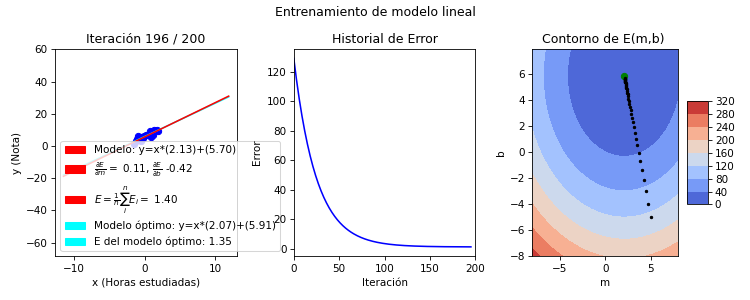

In [46]:
import time
## Carga de datos
data=rnutil.load_dataset_numpy("study_regression_small.csv")
x,y=data[:,0],data[:,1]

## COMIENZO NORMALIZAR
x_media = np.mean(x)
x_desvio = np.std(x)
x = (x - x_media) / x_desvio

## FIN NORMALIZAR


## Parámetros iniciales del modelo (probar valores entre -5 y 5)
m=5
b=-5
# Configuración del descenso de gradiente

#iteraciones máximas a realizar
max_iterations=200
#velocidad de aprendizaje
#valores sensatos: entre 0.00001 y 0.001 (pero probar otros también!)
alpha=0.01
#fin Configuración

# Cálculo del valor óptimo mediante cuadrados mínimos
optimal=optimal_model(x,y)

# Inicialización del algoritmo
iteration=0
mean_error=0
error_history=[]
# Fin inicialización del algoritmo

# Cuadros por segundo (velocidad de dibujado)
# Cuanto más grande, se pausa por menos tiempo entre cada iteración
# No modifica como funciona el algoritmo, solo la visualización
fps=5

#Fin opciones de visualización
plot_state=init_plot(x,y,optimal,m,b)
optimization_state= OptimizationState(max_iterations=max_iterations,error_history=[])

# Optimización con descenso de gradiente    
while iteration<optimization_state.max_iterations:

    # Calcular predicciones y error
    #predicciones del modelo
    yhat=x*m+b
    # ERROR del modelo
    # error de cada ejemplo Ei
    errors= (y-yhat)**2
    # Error total E
    mean_error=errors.mean()
    
    #actualizar datos para plotear (no es necesario en el algoritmo)
    optimization_state.error_history.append(mean_error)
    
    #calculo de derivadas (para usar luego en descenso de gradiente)
    dEdm=2*((yhat-y)*x).mean()
    dEdb=2*(yhat-y).mean()
        
    #visualización cada 5 iteraciones (bajar 1 para que sea más frecuente)
    if (iteration % 5 == 0):
        # visualiamos 
        iteration_state=IterationState(iteration,m,b,dEdm, dEdb,yhat,errors,mean_error)
        visualizar(plot_state,x,y,iteration_state,optimal,optimization_state)        
        # pausar el algoritmo para que se pueda ver la actualización
        plt.pause(1/fps)
        
        

    # fin visualización
    
    #DESCENSO DE GRADIENTE
    #actualizo m
    m=m-alpha*dEdm
    #actualizo b
    b=b-alpha*dEdb
    # FIN DESCENSO DE GRADIENTE
    
    iteration+=1

## ETAPA 1 - DATOS SIN NORMALIZAR

### Pregunta 1: ¿Qué valores de `α` permiten que el algoritmo converja? ¿y cuales que converja en un tiempo razonable?

* Valores inferiores a 0.001 permiten que el algoritmo converja. Por ejemplo con el valor 0.005 el algoritmo diverge alejandose de la zona de convergencia
* Mientras menor sea el valor de alfa mayor sera el tiempo en converger a la solucion (y por lo tanto mayor cantidad de iteraciones)

### Pregunta 2: ¿Se alcanza siempre el mínimo global (punto verde)?

No, el punto final se ve fuertemente influenciado por la condiciones iniciales. Por lo tanto el punto final al cual se llegue dependera de las condiciones iniciales

### Pregunta 3: ¿Qué parámetro importa más para la optimización? La magnitud de las derivadas ¿es la misma para ambos?

* Seleccionado un par de valores iniciales (m,b) se observa que el parametro que modifica fuertemente su valor con respecto al inicial es m, por lo tanto considero que este es el parametro que mas importa para la optimizacion
* La magnitud de las derivadas no es la misma para los parametros m y b: Para ambos parametros el valor de la derivada se ve modificada en cada paso, pero esta razon de cambio se observa mayor para el parametro m


Otras Observaciones:

* Sin dudas la tasa de aprendizaje alfa es determinante en la condicion de convergencia / no convergencia del algoritmo: Una imncorrecta seleccion del valor de alfa puede llevar al algoritmo a no coverger
* Para valores de alfa que generan convergencia del algoritmo es importante un numero minimo de iteraciones de forma tal de garantizar el plateau (meseta) en el valor del error
* Tambien es importante remarcar que el valor final al cual se llefue se ve fuertemente influenciado por las condiciones iniciales de los parametros a optimizar

### Pregunta 4: ¿Se avanza lo mismo en todas las iteraciones (relacionar con magnitud de derivadas)?

El avance esta relacionada con la magnitud de la derivada en el paso donde me encuentre, por lo tanto el avance no sera constante: Al principio se avanzara rapidamente y cuando se va llegando el minimo el avance se reduce 

## ETAPA 2 - DATOS NORMALIZADOS

### Pregunta 1: ¿Qué valores de `α` permiten que el algoritmo converja? ¿y cuales que converja en un tiempo razonable?

* Se observa que con los datos normalizados es posible utilizar valores de alfa grandes, por ejemplo 0.1. Valores superiores a 0.8 genera una divergencia en el algoritmo
* Mientras menor sea el valor de alfa mayor sera el tiempo en converger a la solucion (y por lo tanto mayor cantidad de iteraciones)

### Pregunta 2: ¿Se alcanza siempre el mínimo global (punto verde)?

No necesariamente. Con un valor correcto de alfa y cantidad de iteraciones es posible llegar al minimo global.

A veces seleccionando correctamente el valor de alfa no alcanza la cantidad de iteraciones y nos quedamos "a mitad de camino"

### Pregunta 3: ¿Qué parámetro importa más para la optimización? La magnitud de las derivadas ¿es la misma para ambos?

* Seleccionado un par de valores iniciales (m,b) se observa que el parametro que modifica fuertemente su valor con respecto al inicial es m, por lo tanto considero que este es el parametro que mas importa para la optimizacion
* La magnitud de las derivadas no es la misma para los parametros m y b: Para ambos parametros el valor de la derivada se ve modificada en cada paso, pero esta razon de cambio se observa mayor para el parametro b

### Pregunta 4: ¿Se avanza lo mismo en todas las iteraciones (relacionar con magnitud de derivadas)?

El avance esta relacionada con la magnitud de la derivada en el paso donde me encuentre, por lo tanto el avance no sera constante: Al principio se avanzara rapidamente y cuando se va llegando el minimo el avance se reduce 